<img style="float:left" src="julialogo-smaller.png"/>

<br>
   * innovative open-source scientific programming language
   * **easy as Matlab, fast as Fortran, flexible as Python, deep as LISP**
   * leverages major C/Fortran science packages, e.g. LAPACK, MPI, FFTW... 
   * 5th language to run at 1 petaflops, after assembly, Fortran, C, C++ 
   * the future of scientific computing!
   
-- talk by John Gibson, Mathematics & Statistics, U New Hampshire

<br> 

# Background


  * started as MIT/UCSB applied math & computer science collaboration 2010 
    
  * founders Viral Shah, Jeff Bezanson, Stefan Karpinsky (now at Julia Computing LLC), Alan Edelman (MIT)
        
  * ~10-person core language team, ~600 contributors, ~1000 registered packages 
    
  * support from Intel, Microsoft, Wall St., Moore Foundation, NumFocus
   
  * julia-0.1 released 2012, julia-0.6 2017, julia-1.0 target August 2018
  <br> <br> <br> <br> <br>

# Easy as Matlab


### Linear algebra 

In [2]:
A = randn(4,4)

4×4 Array{Float64,2}:
  2.57783    1.17674    0.376865   2.13483  
 -0.481485   1.22715   -0.907967  -0.946096 
 -0.515887  -0.655537  -0.760206   1.01467  
  0.825816   1.29985    0.902394   0.0693021

In [3]:
A[:,1]                # familiar colon syntax

4-element Array{Float64,1}:
  2.57783 
 -0.481485
 -0.515887
  0.825816

In [4]:
b = randn(4)          
x = A\b               # backslash operator
norm(A*x-b)

1.3092278833360675e-16

In [5]:
U, Σ, V = svd(A);     # unicode variable name Σ
Σ

4-element Array{Float64,1}:
 3.82761 
 2.19883 
 1.41071 
 0.452994

### Numerical integration of ODE

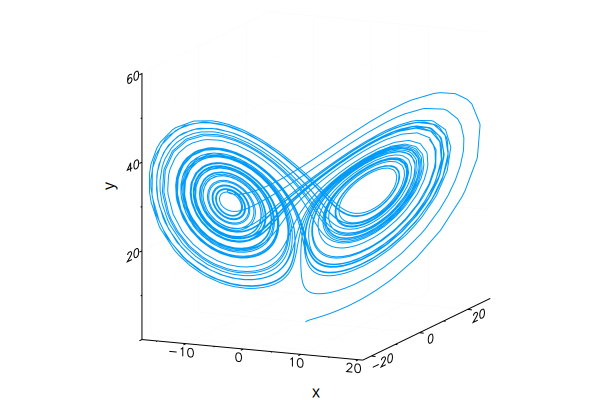

In [6]:
# define Lorenz dynamics ẋ = lorenz(t,x)
function lorenz(t, x)
    σ = 10
    β = 8/3
    ρ = 28
    [σ*(x[2]-x[1]); x[1]*(ρ-x[3]); x[1]*x[2] - β*x[3]]
end

# integrate ẋ = lorenz(t,x) numerically from t=0 to t=50
tspan = 0:0.02:50.0
x₀ = [1.0; 0.0; 0.0]
t,x = ode45(lorenz, x₀, tspan)
y = x
x = hcat(x...)';

# plot Lorenz attractor
plot(x[:,1], x[:,2], x[:,3], l=:path3d, xlab="x", ylab="y", zlab="z", label="")

### Going beyond Matlab

quick demo of slick syntax, macros, and comprehensive numerical type system

In [7]:
⊕ = (x,y) -> 3x + 2y       # define ⊕ operator (unicode program text)

@show 5 ⊕ 1;   println()   # apply ⊕ to two Int64s

@show 2//5 ⊕ (3 - 7im);    # Rational{Int64} ⊕ Complex{Int64} produces Complex{Rational{Int64}

5 ⊕ 1 = 17

2 // 5 ⊕ (3 - 7im) = 36//5 - 14//1*im


<br> <br> <br> <br> <br>


# Julia: fast as Fortran

### Kuramoto-Sivashinsky equation

The Kuramoto-Sivashinsky (KS) equation is a nonlinear time-evolving partial differential equation (PDE) on a 1d spatial domain.

\begin{equation*}
u_t = - u_{xx} - u_{xxxx} - u u_x
\end{equation*}

where $x$ is space, $t$ is time, and subscripts indicate differentiation. We assume a spatial domain $x \in [0, L_x]$ with periodic boundary conditions and initial condition $u(x,0) = u_0(x)$. 

### KS-CNAB2 integration algorithm

Represent the linear terms as $Lu = (-D^2 -D^4)\, u$ and the nonlinear term as $N(u) = 1/2\, D \,u^2$ where $D = \partial/\partial x$.

\begin{equation*}
u_t = Lu + N(u)
\end{equation*}

Discretize time by letting $u^n(x) = u(x, n\Delta t)$ for some small $\Delta t$, and use Crank-Nicolson, Adams-Bashforth (CNAB2) timestepping. 

\begin{equation*}
\frac{u^{n+1} - u^n}{\Delta t} = L\left(\frac{u^{n+1} + u^n}{2} \right) + \frac{3}{2} N(u^n) - \frac{1}{2} N(u^{n-1})
\end{equation*}


Put the unknowns (future) $u^{n+1}$'s on the LHS and knowns (past) $u^{n}$ and past $u^{n+1}$ on the RHS.

\begin{equation*}
\left(I  - \frac{\Delta t}{2} L \right) u^{n+1} = \left(I  + \frac{\Delta t}{2}L \right) u^{n} + \frac{3 \Delta t}{2} N(u^n) - \frac{\Delta t}{2} N(u^{n-1})
\end{equation*}

Discretize space with a finite Fourier transform, so that $(I  \mp \Delta t/2 \, L)$ becomes diagonal matrices $A$ and $B$, and $N^n$ is the Fourier transform of $N(u^n)$.

\begin{equation*}
A \, u^{n+1} = B \, u^n + \frac{3 \Delta t}{2} N^n -  \frac{\Delta t}{2}N^{n-1}
\end{equation*}

This is an $Ax=b$ problem whose iteration approximates the time-evolution of the Kuramoto-Sivashinksy PDE. 

### Julia code for KS-CNAB2 algorithm

In [8]:
function ksintegrate(u₀, Lₓ, Δt, Nsteps, nsave);
    uⁿ = (1+0im)*u₀                      # force u to be complex
    Nₓ = length(uⁿ)                       # number of gridpoints
    kₓ = vcat(0:Nₓ/2-1, 0:0, -Nₓ/2+1:-1)  # integer wavenumbers: exp(2πikₓ x/L)
    α  = 2*pi*kₓ/Lₓ                       # real wavenumbers:    exp(iαx)
    D  = 1im*α                           # spectral D = d/dx operator 
    L  = α.^2 - α.^4                     # spectral L = -D^2 - D^4 operator
    G  = -0.5*D                          # spectral -1/2 D operator
    
    Nsave = div(Nsteps, nsave)+1         # number of saved u's, including t=0
    t = (0:Nsave)*(Δt*nsave)             # times of saved u's
    U = zeros(Nsave, Nₓ)                 # matrix of u(tᵢ, xⱼ) values
    U[1,:] = real(u₀)                    # assign initial condition to U
    s = 2                                # counter for saved data
    
    # construct diagonal matrices for LHS and RHS linear operators
    I   = ones(Nₓ)
    A⁻¹ = (I - Δt/2*L).^(-1)             
    B   = I + Δt/2*L
    
    # compute in-place FFTW plans
    FFT!  = plan_fft!(uⁿ,  flags=FFTW.ESTIMATE)
    IFFT! = plan_ifft!(uⁿ, flags=FFTW.ESTIMATE)

    # initialize nonlinear terms 
    Nuⁿ  = G.*fft(uⁿ.^2)      # set Nuⁿ = -1/2 d/dx (uⁿ)² = -u uₓ 
    Nuⁿ⁻¹ = copy(Nuⁿ)         # set Nuⁿ⁻¹ = Nuⁿ for first time step
    FFT!*uⁿ
    
    # timestepping loop
    for n = 1:Nsteps
        
        Nuⁿ⁻¹ .= Nuⁿ        # shift nonlinear term in time
        Nuⁿ  .= uⁿ         # store uⁿ in Nuⁿ in prep for collocation computation
        
        IFFT!*Nuⁿ          # transform to gridpt values of u
        Nuⁿ .= Nuⁿ.*Nuⁿ    # collocation calculation of u²
        FFT!*Nuⁿ           # transform u² back to spectral coeffs

        Nuⁿ .= G.*Nuⁿ      # compute  Nuⁿ = -1/2 d/dx u² = -u uₓ

        # Loop fusion! Julia unrolls this line into a single for-loop over vector elems,
        # avoiding the generation and allocation of temporary vectors you'd get in Matlab
        uⁿ .= A⁻¹ .* (B .* uⁿ .+ 3Δt/2.*Nuⁿ .- Δt/2.*Nuⁿ⁻¹)
        
        if mod(n, nsave) == 0
            U[s,:] = real(ifft(uⁿ))  # save into return matrix U 
            s += 1            
        end
    end
   
    t,U
end

ksintegrate (generic function with 1 method)

### Execute Julia KS-CNAB2 code

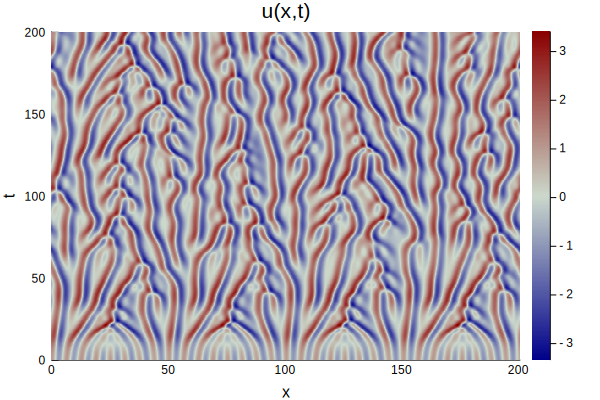

In [9]:
# set discretization parameters
Lx = 64π
Nx = 1024
Δt = 1/16
nsave = 8
Nsteps = 3200

# set initial condition
x = Lx*(0:Nx-1)/Nx
u₀ = cos.(x) + 0.1*sin.(x/8) + 0.01*cos.(x/32);

# integrate PDE
t,U = ksintegrate(u₀, Lx, Δt, Nsteps, nsave) 

# plot results
heatmap(x,t, U, xlim=(x[1], x[end]), ylim=(t[1], t[end]), xlabel="x", ylabel="t", title="u(x,t)", fillcolor=:bluesreds)

### KS-CNAB2 benchmark: CPU time versus gridsize

Identical algorithm in six languages

<img style="float:left" src="ks_cpu_scaling.svg"/>

### KS-CNAB2 benchmark: CPU time versus lines of code 

<img style="float:left" src="ks_cpu_vs_lines.svg"/>


### Benchmarks on common code pattterns (hot loops)

<img style="float:left" src="benchmarks.svg"/>


# Julia: easy, dynamic, and fast. How? 


### Just-in-time compilation

Functions are compiled to machine code when first run. Subsequent runs are as fast as compiled C, C++, Fortran.

#### Logistic map example $f(x) = 4x(1-x)$.


In [10]:
f(x) = 4x*(1-x)     # define logistic map
@time f(0.3);       # run it once
@time f(0.3);       # run it again, faster by a factor of thousands

  0.002166 seconds (497 allocations: 29.339 KiB)
  0.000001 seconds (4 allocations: 160 bytes)


In [11]:
@time f(0.67)

  0.000001 seconds (5 allocations: 176 bytes)


0.8844

In [12]:
@code_llvm f(0.3)   # show f(x) in intermediate compiler language (LLVM)


define double @julia_f_64640(double) #0 !dbg !5 {
top:
  %1 = fmul double %0, 4.000000e+00
  %2 = fsub double 1.000000e+00, %0
  %3 = fmul double %1, %2
  ret double %3
}


In [13]:
@code_native f(0.3) # show f(x) in IA-64 assembly language

	.text
Filename: In[10]
	pushq	%rbp
	movq	%rsp, %rbp
	movabsq	$140123479490144, %rax  # imm = 0x7F710A383E60
	movabsq	$140123479490152, %rcx  # imm = 0x7F710A383E68
Source line: 1
	movsd	(%rcx), %xmm1           # xmm1 = mem[0],zero
	subsd	%xmm0, %xmm1
	mulsd	(%rax), %xmm0
	mulsd	%xmm1, %xmm0
	popq	%rbp
	retq
	nopw	(%rax,%rax)


#### Millionth iterate of logistic map, Julia

In [14]:
# define function that, given function g(x), returns iterated function gᴺ(x)
function iterator(g, N)
    
    # construct gᴺ, the Nth iterate of g
    function gᴺ(x)
      for i ∈ 1:N             
        x = g(x)
      end        
      return x
    end    
    
    return gᴺ
end

# use iterator function to generate millionth iterate function for logistic map
fᴺ = iterator(f, 10^6);

@time x = fᴺ(0.67)
@time x = fᴺ(0.67);

  0.007539 seconds (1.04 k allocations: 54.685 KiB)
  0.002831 seconds (5 allocations: 176 bytes)


#### Millionth iterate of logistic map, C++

In [15]:
; cat fN.cpp

#include <stdlib.h>
#include <iostream>
#include <iomanip>
#include <ctime>

using namespace std;

inline double f(double x) {
  return 4*x*(1-x);
}

int main(int argc, char* argv[]) {
  double x = argc > 1 ? atof(argv[1]) : 0.0;

  double t0 = clock();
  for (int n=0; n<1000000; ++n)
    x = f(x);
  double t1 = clock();

  cout << "t = " << (t1-t0)/CLOCKS_PER_SEC << " seconds" << endl;
  cout << setprecision(17);
  cout << "x = " << x << endl;
  
  return 0;
}
  


In [16]:
; g++ -O3 -o fN fN.cpp -lm  

### Compare execution time of fN in Julia, C++, Matlab

#### Julia

In [17]:
print("t=");                 # run the Julia fᴺ on x = 0.67
@time x = fᴺ(0.67);
@show x;

t=  0.002747 seconds (5 allocations: 176 bytes)
x = 0.10116885334547539


#### C++

In [18]:
; fN 0.67 

t = 0.002743 seconds
x = 0.10116885334547539


Julia and C++ get the same result `x` in roughly same execution time `t`. Sometimes Julia is faster, sometimes C++.

#### Matlab
```
>> tic(); x=fN(0.67); t=toc();
>> t, x
t = 0.048889000000000
x = 0.101168853345475
```
Matlab gets the same result $x$, but ten to twenty times slower than Julia or C++.

## Type inference

Julia reasons about types and infers types of variables from context, enabling compilation to hardware instructions. 

Language and type system carefully designed maximize effectiveness of just-in-time compilation. Matlab, Python syntax precludes this.



In [19]:
# recall definition of f(x): no types are mentioned!
f(x) = 4x*(1-x)

f (generic function with 1 method)

In [20]:
typeof(f)

#f

In [21]:
@code_llvm f(0.3)   # machine code for f applied to Float64 argument


define double @julia_f_64753(double) #0 !dbg !5 {
top:
  %1 = fmul double %0, 4.000000e+00
  %2 = fsub double 1.000000e+00, %0
  %3 = fmul double %1, %2
  ret double %3
}


In [22]:
@code_llvm f(2)     # machine code for f applied to Int64 argument


define i64 @julia_f_64755(i64) #0 !dbg !5 {
top:
  %1 = shl i64 %0, 2
  %2 = sub i64 1, %0
  %3 = mul i64 %1, %2
  ret i64 %3
}


In [23]:
@code_llvm fᴺ(0.67) 


define double @"julia_g\E1\B4\BA_64756"(%"#g\E1\B4\BA#15"* nocapture readonly dereferenceable(8), double) #0 !dbg !5 {
top:
  %2 = getelementptr inbounds %"#g\E1\B4\BA#15", %"#g\E1\B4\BA#15"* %0, i64 0, i32 1
  %3 = load i64, i64* %2, align 8
  %4 = icmp slt i64 %3, 1
  br i1 %4, label %L14, label %if.preheader

if.preheader:                                     ; preds = %top
  br label %if

if:                                               ; preds = %if.preheader, %if
  %x.03 = phi double [ %8, %if ], [ %1, %if.preheader ]
  %"#temp#.02" = phi i64 [ %5, %if ], [ 1, %if.preheader ]
  %5 = add i64 %"#temp#.02", 1
  %6 = fmul double %x.03, 4.000000e+00
  %7 = fsub double 1.000000e+00, %x.03
  %8 = fmul double %6, %7
  %9 = icmp eq i64 %"#temp#.02", %3
  br i1 %9, label %L14.loopexit, label %if

L14.loopexit:                                     ; preds = %if
  br label %L14

L14:                                              ; preds = %L14.loopexit, %top
  %x.0.lcssa = phi double [ %1, %t

<br> <br> <br> <br>

# Julia: flexible as Python

### Comprehensive numeric type system

In [24]:
# define a set of various numeric types
X = (1, 0.5f0, 0.5, 2//3, 2+3im, 2.1 + 4.3im, 2//3 + 4//5im, BigFloat(2//3), BigFloat(2//3) + BigFloat(4//5)*im);

# loop over elements of X, print type and compute value of logistic map f(x)
for x ∈ X
    println("typeof(x) = $(typeof(x)), f(x) = $(f(x))\n")
end

typeof(x) = Int64, f(x) = 0

typeof(x) = Float32, f(x) = 1.0

typeof(x) = Float64, f(x) = 1.0

typeof(x) = Rational{Int64}, f(x) = 8//9

typeof(x) = Complex{Int64}, f(x) = 28 - 36im

typeof(x) = Complex{Float64}, f(x) = 64.72 - 55.04im

typeof(x) = Complex{Rational{Int64}}, f(x) = 776//225 + 16//15*im

typeof(x) = BigFloat, f(x) = 8.88888888888888888888888888888888888888888888888888888888888888888888888888887e-01

typeof(x) = Complex{BigFloat}, f(x) = 3.448888888888888888888888888888888888888888888888888888888888888888888888888868 - 1.066666666666666666666666666666666666666666666666666666666666666666666666666692im



In [25]:
# exact arithmetic: compute iterated logisitic map on Rational{BigInt}
fᴺ = iterator(f, 7)
@show fᴺ(big(2//3));

fᴺ(big(2 // 3)) = 674838593766753484487654913831820720085359667709963001167872//11790184577738583171520872861412518665678211592275841109096961


### Singular values of Hilbert matrix

The Hilbert matrix $A_{ij} = (i+j-1)^{-1}$ is notoriously ill-conditioned. 

In [26]:
m = 8
A = [1//(i+j-1) for i=1:m, j=1:m]    # 8 x 8 Hilbert matrix of Rationals

8×8 Array{Rational{Int64},2}:
 1//1  1//2  1//3   1//4   1//5   1//6   1//7   1//8 
 1//2  1//3  1//4   1//5   1//6   1//7   1//8   1//9 
 1//3  1//4  1//5   1//6   1//7   1//8   1//9   1//10
 1//4  1//5  1//6   1//7   1//8   1//9   1//10  1//11
 1//5  1//6  1//7   1//8   1//9   1//10  1//11  1//12
 1//6  1//7  1//8   1//9   1//10  1//11  1//12  1//13
 1//7  1//8  1//9   1//10  1//11  1//12  1//13  1//14
 1//8  1//9  1//10  1//11  1//12  1//13  1//14  1//15

In [27]:
# 16 x 16 Hilbert is too ill-conditioned for 64-bit arithmetic 
m = 16
A = [1/(i+j-1) for i=1:m, j=1:m]    # 16 x 16 Hilbert matrix of Float64s
@show cond(A)
@show eps(Float64)

cond(A) = 3.535827507735838e17
eps(Float64) = 2.220446049250313e-16


2.220446049250313e-16

In [28]:
# Make 32 x 32 Hilbert matrix of BigFloats and show a few elements

m = 32
A = [BigFloat(1//(i+j-1)) for i=1:m, j=1:m]; 
@show A[1,1]
@show A[2,1]
@show A[3,1]
;

A[1, 1] = 1.000000000000000000000000000000000000000000000000000000000000000000000000000000
A[2, 1] = 5.000000000000000000000000000000000000000000000000000000000000000000000000000000e-01
A[3, 1] = 3.333333333333333333333333333333333333333333333333333333333333333333333333333348e-01


In [29]:
# Compute singular values of 32 x 32 Hilbert matrix in 256-bit arithmetic
σ = svdvals(A)

32-element Array{BigFloat,1}:
 1.998434811479943656818393069323257960640895672475752391825234214538557962751571    
 5.862023373833755450036553769152732128253887467482456889981306320710605366320407e-01
 1.10847523452293641165712019076916986852940670606685497550561288825334330556402e-01 
 1.673319658958179140677531975263979754746187466404676472020306095015480020192925e-02
 2.15575491554152836754878398453770830758654707824868046467567877302736921411345e-03 
 2.430276596697422938228473142877594100259722632966877505528956749837836051990004e-04
 2.429495582927391325328945583959494719139547266197054564322197618596025730380946e-05
 2.171522505963389703148618411661941671277063234196349157743888780845209557391788e-06
 1.744940782252377496458626015544168389499120927266562258019751784656307464036591e-07
 1.265263755175621542941323081140106746391741410303876700785990407921028286492275e-08
 8.299361818990081080483039727963430527712415734657494874743550521365933062548887e-10
 4.932225502812551689960

## User-defined type: Galois field GF(p)

Finite scalar field GF(p) is $\mathbb{Z}/p$, the integers modulo p, where p is prime. Example by Andreas Noack, Julia Computing.

In [30]:
# Define Galois fields GF(p), where p is the prime modulus, T is the integer type
immutable GF{p,T} <: Number where {p,T<:Integer}
    rep::T  # representative integer which holds the value of a GF(p) variable
    function GF{p,T}(x::Integer) where {p,T<:Integer}
        return new(mod(x, p))
    end
end
GF{p}(x::T) where {p,T<:Integer} = GF{p,T}(x)


# Define some basic methods for GF(p) that all Julia Numbers must have
import Base: convert, inv, one, promote_rule, show, zero

function call{p}(::Type{GF{p}}, x::Integer)
    if !isprime(p)
        throw(ArgumentError("p must be prime"))
    end
    return GF{p,typeof(x)}(mod(x, p))
end

convert{p,T}(::Type{GF{p,T}}, x::Integer) = GF{p}(x)
convert{p}(::Type{GF{p}}, x::Integer) = GF{p}(x)
convert{p,T}(::Type{GF{p,T}}, x::GF{p}) = GF{p,T}(x.rep)
promote_rule{p,T1,T2<:Integer}(::Type{GF{p,T1}}, ::Type{T2}) = GF{p,promote_type(T1,T2)}
show(io::IO, x::GF) = show(io, x.rep);


# Define arithmetic operations on GF(p)
import Base: +, -, *, /

for op in (:+, :-, :*)   # loop over ops, defining each in terms of integer ops mod p
    @eval begin
        ($op){p,T}(x::GF{p,T}, y::GF{p,T}) = GF{p,T}($(op)(x.rep, y.rep))
    end
end

# Define inverse and ÷. Requires more care than +, -, * because dividing by zero throws error
function inv{p,T}(x::GF{p,T})
    if x == zero(x)
        throw(DivideError())
    end
    r, u, v = gcdx(x.rep, p)
    GF{p,T}(u)
end
(/){p}(x::GF{p}, y::GF{p}) = x*inv(y);

In [31]:
# Create some GF(7) variables and do arithmetic

x = GF{7}(9)   # x =  9 mod 7 = 2
y = GF{7}(12)  # y = 12 mod 7 = 5
@show x
@show y
@show x + y     # 2 + 5 mod 7 = 0
@show x - y     # 2 - 5 mod 7 = 4
@show x * y     # 2 * 5 mod 7 = 3
@show x / y     # 2 ÷ 5 mod 7 = 6, because 2 = 6*5 mod 7
;

x = 2
y = 5
x + y = 0
x - y = 4
x * y = 3
x / y = 6


### Linear algebra over Galois field

In [32]:
srand(1234)
A = [GF{7}(rand(0:6)) for i = 1:4, j = 1:4] # matrix of random GF(7) elems

4×4 Array{GF{7,Int64},2}:
 3  5  3  3
 6  6  2  0
 2  2  6  4
 2  6  1  2

In [33]:
b = [GF{7}(rand(0:6)) for i = 1:4]          # random vector b for Ax=b problem

4-element Array{GF{7,Int64},1}:
 1
 4
 3
 0

In [34]:
x = A\b   # solve Ax=b over GF(p)!

4-element Array{GF{7,Int64},1}:
 5
 5
 0
 1

In [35]:
A*x - b   # check that x satisfies Ax=b

4-element Array{GF{7,Int64},1}:
 0
 0
 0
 0

**Whoa! Built-in backslash operator on matrix of GF(p) worked!** 

Julia generated and compiled a GF(p)-specific version of its generic LU decomp function. 

All it needs is definitions of $+, -, \times, \div$.

<br> <br> <br> <br>




# Julia: deep as Lisp

Julia is *homoiconic*: it can represent its own expressions as data structures and operate on them

### Expressions

In [36]:
program = "for n ∈ 1:N begin println(n^2) end end"

"for n ∈ 1:N begin println(n^2) end end"

In [37]:
expression = parse(program)

:(for n = 1:N # none, line 1:
        begin  # none, line 1:
            println(n ^ 2)
        end
    end)

In [38]:
dump(expression)

Expr
  head: Symbol for
  args: Array{Any}((2,))
    1: Expr
      head: Symbol =
      args: Array{Any}((2,))
        1: Symbol n
        2: Expr
          head: Symbol :
          args: Array{Any}((2,))
            1: Int64 1
            2: Symbol N
          typ: Any
      typ: Any
    2: Expr
      head: Symbol block
      args: Array{Any}((2,))
        1: Expr
          head: Symbol line
          args: Array{Any}((2,))
            1: Int64 1
            2: Symbol none
          typ: Any
        2: Expr
          head: Symbol block
          args: Array{Any}((2,))
            1: Expr
              head: Symbol line
              args: Array{Any}((2,))
                1: Int64 1
                2: Symbol none
              typ: Any
            2: Expr
              head: Symbol call
              args: Array{Any}((2,))
                1: Symbol println
                2: Expr
              typ: Any
          typ: Any
      typ: Any
  typ: Any


In [39]:
program

"for n ∈ 1:N begin println(n^2) end end"

In [40]:
N = 3; eval(expression)

1
4
9


In [41]:
N = 5; eval(expression)

1
4
9
16
25


### Macros: code that transforms code

In [42]:
# @show macro prints expression, an equals sign, then evaluates the expr and prints its value
@show 3*A[:,1] + 7*A[:,2];

3 * A[:, 1] + 7 * A[:, 2] = GF{7,Int64}[2, 4, 6, 6]


In [43]:
# @time macro inserts timing and memory profiling into expression, then evaluates, and prints
@time f(2//3)

  0.004118 seconds (404 allocations: 22.577 KiB)


8//9

In [44]:
# @which macro determines which function is called, provides link to source code on GitHub
@which exp(π)

exp(x::Real) in Base.Math at math.jl:243

In [45]:
@which exp(π*im)

exp(z::Complex) in Base at complex.jl:502

In [46]:
# run-time code generation and evaluation using @eval macro (example from Galois field GF(p))

for op in (:+, :-, :*)   # loop over ops, defining each in terms of integer ops mod p
    @eval begin
        ($op){p,T}(x::GF{p,T}, y::GF{p,T}) = GF{p,T}($(op)(x.rep, y.rep))
    end
end

Macros enable run-time code generation and transformation. Applications

  * generation and execution of boilerplate code
  * run-time generation and optimization of algorithms, e.g. FFTW, ATLAS
  * automatic diferentiation
  * symbolic mathematics
  * *all written like high-level Python, running like compiled C !!!*

# Conclusions

Julia
  * easy as Matlab, fast as Fortran, flexible as Python, deep as Lisp
  * poised to take over scientific computing, from interactive exploration to HPC

Not covered
  * parallel programming: MPI and higher-level constructs
  * large-scale programming, development ecosystem, environments, debuggers, etc.
  * interfaces to major C/Fortran libraries, e.g. LAPACK, MPI, FFTW, PETSc, etc.   
  * rough edges: plotting, package loading times, syntax flux

Thanks
  * Julia team, Julia community
  * David Sanders, National University of Mexico City
  * Andreas Noack, Julia Computing 
  * Mahtab Lak, UNH Math Ph.D. student

  
Julia website: http://www.julialang.org, this talk: https://github.com/johnfgibson/whyjulia
<br> <br> <br>  <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br>

#### Preload and run some functions

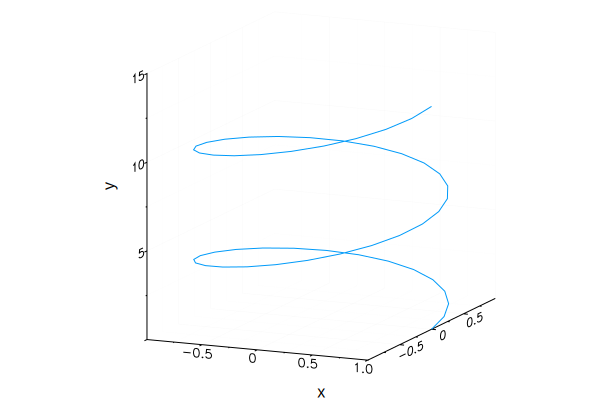

In [1]:
using ODE, Plots, GenericSVD     # load some packages 
gr();                            # set plotting backend
t = linspace(0,4π)
x,y,z = cos.(t), sin.(t), t
plot(x, y, z, l=:path3d, xlab="x", ylab="y", zlab="z", label="")